---
title: Which Sketch Should I Use?
description: Comparative analysis of different sketching methods including performance benchmarks and distortion measurements
keywords: [sketch comparison, Gaussian sketch, trigonometric sketch, sparse sketch, performance benchmarks, distortion analysis]
numbering:
  equation:
    enumerator: 2.%s
    continue: true
  proof:theorem:
    enumerator: 2.%s
    continue: true
  proof:algorithm:
    enumerator: 2.%s
    continue: true
  proof:definition:
    enumerator: 2.%s
    continue: true
  proof:proposition:
    enumerator: 2.%s
    continue: true
---

*This section shares the title of Ethan's [blog post](https://www.ethanepperly.com/index.php/2023/11/27/which-sketch-should-i-use/), which inspired the design of the experiments we conduct here.*


In the past several sections, we have seen several oblivious sketching methods. 
Which one should we use?

In short, we recommend [Sparse Sketches](./sparse-sketch.md) as a good default choice. 
In settings where dense matrix-matrix multiplication is highly optimized (e.g. when working with relatively small matrices on GPUs), dense sketches may be preferable.

## Comparison

The following summarizes the performance of the different sketching methods we have seen so far.

| Sketch Type | Embedding dimension $k$ | Apply Cost |
|-------------|------------|------|
| Gaussian Sketch | $O(d)$ | $O(\nnz(\vec{A}) k)$ |
| Trigonometric Sketch | $O(d\log(d))$ | $O(n d \log (n))$ | 
| SparseStack | $O(d)$ | $O(\nnz(\vec{A}) \log (d))$ |


Theoretically, SparseStack sketches seem to be the best choice. 
They achieve an optimal embedding dimension $O(d)$ and are efficient to apply to both dense and sparse $\vec{A}$.


## Numerical Experiments

We now perform some numerical comparisons which show that SparseStack sketches are a good choice in practice as well.

In [11]:
import numpy as np
import scipy as sp
from scipy import fft,sparse
import pandas as pd
import time
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from randnla import *

In [12]:
n = 2**14
d = 200

A = np.random.randn(n,d)
A_s = sp.sparse.random(n,d, density=0.01).tocsr()

In [13]:
sketch_methods = {
    'Gaussian': {
        'func': lambda k,rng: gaussian_sketch(n,k,rng),
    },
    'Trig': {
        'func': lambda k,rng: trig_sketch(n,k,rng),
    },
    'Sparse (zeta=4)': {
        'func': lambda k,rng: sparse_stack_sketch(n,k,4,rng),
    },
    'Sparse (zeta=8)': {
        'func': lambda k,rng: sparse_stack_sketch(n,k,8,rng),
    },
}


## Generate / Apply Cost

We begin by comparing the cost of generating and applying the different sketches.
When timing the apply time, we consider the time to apply the sketch matrix to a dense matrix $\vec{A}$, as well as the time to apply the sketch matrix to a sparse matrix $\vec{A}$.

In [14]:
k = 10*d

n_repeat = 1

results = []

for method_name, method_info in sketch_methods.items():
    # Time the method
    start = time.time()
    for i in range(n_repeat):
        rng = np.random.RandomState(i)
        S = method_info['func'](k,rng)
    end = time.time()
    
    avg_gen_time = (end - start) / n_repeat

    start = time.time()
    for i in range(n_repeat):
        S@A
    end = time.time()
    
    avg_dense_apply_time = (end - start) / n_repeat 

    start = time.time()
    for i in range(n_repeat):
        S@A_s
    end = time.time()
    
    avg_sparse_apply_time = (end - start) / n_repeat 
    
    # Compute accuracy metrics
    results.append({
        'method': method_name,
        'gen. time (s)': avg_gen_time,
        'apply to dense time (s)': avg_dense_apply_time,
        'apply to sparse time (s)': avg_sparse_apply_time,
    })


# Create DataFrame and compute relative performance
results_df = pd.DataFrame(results)

# Display results with formatting
results_df.style.format({
    'gen. time (s)': '{:1.2e}',
    'apply to dense time (s)': '{:1.2e}',
    'apply to sparse time (s)': '{:1.2e}'
})

,method,gen. time (s),apply to dense time (s),apply to sparse time (s)
0,Gaussian,2.12e+00,5.34e-01,1.11e-01
1,Trig,5.90e-03,1.43e-01,2.14e-01
2,Sparse (zeta=4),6.23e-03,3.19e-02,7.31e-03
3,Sparse (zeta=8),8.55e-03,4.04e-02,1.10e-02


The results of the experiment are essentially as expected. 
We emphasize that SparseStack sketches are able to take advantage of sparsity in $\vec{A}$, which is not the case for trig sketches.

Note also that generating a Gaussian sketch is extremely expensive!

## Distortion

We now consider the distortion of the different sketches for two different subspaces. 
The first subspace is a random subspace, which we generate by sampling a random orthonormal basis, and the second is a subspace spanned by the first $k$ columns of a random matrix $\vec{A}$, which is known to be a hard example for sparse sketching distributions.
We also plot $\epsilon = \sqrt{d/k}$, which is the asymptotic distortion for large Gaussian matrices. 

In [15]:
U,_ = np.linalg.qr(A)

U_hard = np.zeros((n,d))
U_hard[:d] = np.eye(d)

In [16]:
sketch_problems = {
    'typical': {
        'U': U,
    },
    'hard': {
        'U': U_hard,
    },
}

ks = np.geomspace(2*d,1000,10,dtype=int)

n_repeat = 10

results = {}

for problem_name,problem_info in sketch_problems.items():

    U_problem = problem_info['U']
    for method_name, method_info in sketch_methods.items():


        distortion = np.zeros((n_repeat,len(ks)))
        for i in range(n_repeat):
            rng = np.random.RandomState(i)
            for j,k in enumerate(ks):
            
                S = method_info['func'](k,rng)
                Y = S@U_problem

                s = np.linalg.svd(Y,compute_uv=False)
                distortion[i,j] = max(s[0]-1,1-s[-1]) 

        results[problem_name,method_name] = {
            'distortion': distortion,
        }

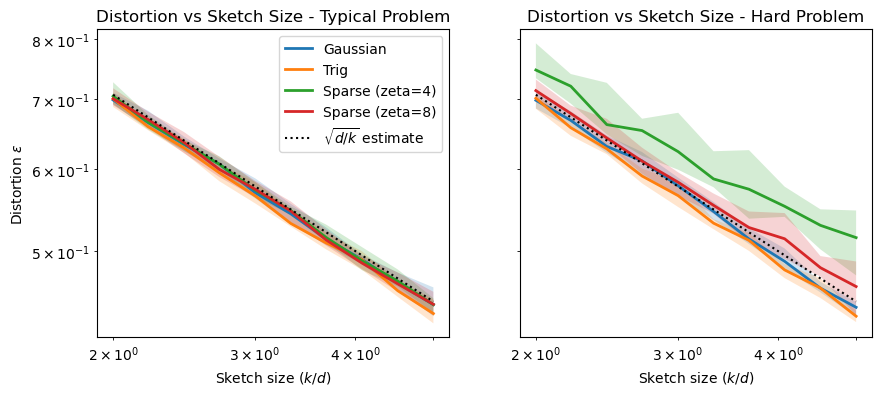

In [17]:
σ = 0.1
fig, axs = plt.subplots(1,len(sketch_problems),figsize=(10, 4),sharey=True)

# Handle case where we only have one subplot
if len(sketch_problems) == 1:
    axs = [axs]

for i, (problem_name, problem_info) in enumerate(sketch_problems.items()):
    ax = axs[i]
    
    for method_name, method_info in sketch_methods.items():
        # Get the distortion data for this problem and method
        distortion = results[problem_name, method_name]['distortion']
        
        bot, mid, top = np.quantile(distortion, [σ, .5, 1-σ], axis=0)
        ax.plot(ks/d, mid, label=method_name, linewidth=2)
        ax.fill_between(ks/d, bot, top, alpha=.2)

    # Theoretical bound
    ax.plot(ks/d, np.sqrt(d/ks), ls=':', color='k', label=r'$\sqrt{d/k}$ estimate')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Sketch size ($k/d$)')
    ax.set_title(f'Distortion vs Sketch Size - {problem_name.capitalize()} Problem')

axs[0].set_ylabel(rf'Distortion $\varepsilon$')
axs[0].legend()


On the typical problem, all sketches perform remarkably similarly to the asymptotic Gaussian rate.
Numerical experiments on a wide range of problems further confirm this observation {cite:p}`chen_niroula_ray_subrahmanya_pistoia_kumar_25,?`.
However, on the hard problem, when the sparsity is too low, the performance of SparseStack sketches degrades slightly. 


